# 06: Multi-layer Neural Networks
NSC 3270 <br>
Due Tues Oct 26 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as R

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers

## All testing / functions to quickly create networks:

In [2]:
def create_network(node_list=[2,2,1], func_list=['relu'], my_opt='adam', loss_func='sparse_categorical_crossentropy'):
    network = models.Sequential()
    for idx, arg in enumerate(node_list):
        if idx == 0:
            n_prev = arg
        elif idx == len(node_list)-1:
            if node_list[-1] == 1 and len(func_list) == 1:
                print("BINARY CLASSIFICATION!")
                my_func = 'sigmoid'
                loss_func = 'binary_crossentropy'
            elif len(func_list) == 1:
                print("MULTICLASS CLASSIFICATION!")
                my_func = 'softmax'
                loss_func = 'categorical_crossentropy'
            else:
                print("CUSTOM CLASSIFICATION!")
                my_func = func_list[-1]
            network.add(layers.Dense(arg, 
                             activation=my_func, 
                             input_shape=(n_prev,)))
        else:
            network.add(layers.Dense(arg, 
                                     activation=func_list[0], 
                                     input_shape=(n_prev,)))
    
    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer=my_opt, 
                    loss=loss_func, 
                    metrics=['accuracy', 'mse'])
    
    return network

In [3]:
def plot_model_acc(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

In [4]:
# function for generating plot for Q4
# xv is array of x-values of test grid (from meshgrid)
# yv is array of y-values of test grid (from meshgrid)
# out is the output of the neural network given the test patterns
# sample0, sample1 are the training patterns from earlier

def plottest(xv, yv, out, sample0, sample1):
    # reshape out
    zv = out.reshape(xv.shape)

    # create figure
    fig = plt.figure()
    plt.contourf(xv, yv, zv, levels=xv.shape[0], cmap=plt.cm.gist_yarg)
    plt.plot(sample0[:,0], sample0[:,1], 'b+', 
             sample1[:,0], sample1[:,1], 'r+')    
    
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.axis('equal')
    plt.axis('square')
    xymin = -10; xymax = 10
    plt.ylim((xymin,xymax))
    plt.xlim((xymin,xymax))
    plt.show()

In [5]:
def run_pipeline(train_array, train_labels_onehot, test_pats, test_labels_onehot_2D, node_list=[2,2,1], func_list=['relu'], my_opt='adam', loss_func='sparse_categorical_crossentropy', num_epochs=30, my_batch=1):
    best_acc = -1
    best_val_acc = -1
    
    if node_list[-1] > 1:
        train_labels_onehot = np.concatenate((train_labels_onehot, np.flip(train_labels_onehot)),axis=1)
    
    for _ in range(5):
        network = create_network(node_list, func_list, my_opt, loss_func)
        history = network.fit(train_array, 
                              train_labels_onehot, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)
        print('Done training!')
        # Determine if this model was better than the previous ones
        new_acc = history.history['acc'][-1]
        new_val_acc = history.history['val_acc'][-1]
        if new_acc > best_acc and new_val_acc > best_val_acc:
            best_acc = new_acc
            best_val_acc = new_val_acc
            best_history = history
            best_network = network
        # Show the accuracy plot each time
        # plot_model_acc(history)

    # Show the accuracy of the best plot
    plot_model_acc(best_history)
    
    out = best_network.predict(
       test_pats, 
       batch_size = my_batch, 
       verbose = 0,  
       workers = 1, 
       use_multiprocessing = False)

    plottest(xv, yv, out, sample0, sample1)
    plottest(xv, yv, test_labels_onehot_2D, sample0, sample1)
    return best_network, best_history, out

## Q1 (2 points)

Use the approach from HW5 to create an XOR problem, allowing for 200 training patterns per category (e.g. 400 total) and assume the same standard deviations/correlations used for HW5.  You will need to format the matrix of training patterns and the matrix of teachers to allow for the problem to be learned by a neural network using Keras.  Display your XOR problem in a figure.

In [6]:
## generate N random samples from a 2D multivariate normal distribution
##
## with mean [mx, my]
##
## with covariance matrix [[  sx*sx, r*sx*sy],
##                         [r*sx*sy,   sy*sy]]
## where sx is the standard deviation along the x dimension
## where sy is the standard deviation along the y dimension
## where r is the correlation between the dimensions
##

def gensamples(N, mx, my, sx, sy, r):
    M   = np.array([mx, my])
    Cov = np.array([[  sx*sx, r*sx*sy],
                    [r*sx*sy,   sy*sy]])
    return (R.multivariate_normal(M, Cov, size=N, check_valid='warn'))

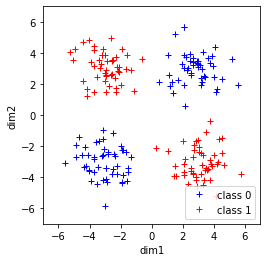

In [7]:
# classification problem used in Q1

# Bottom left
mx0 = -3.;  my0 = -3.
sx0 = 1.;  sy0 = 1.
r0 = 0.
# Top right
mx1 = 3.; my1 = 3.
#######################################################################
# Bottom right
mx3 = 3.;  my3 = -3.
sx3 = 1.; sy3 = 1.
r3 = 0.
# Top left
mx4 = -3.; my4 = 3.
#######################################################################
N = 50
sample_bl = gensamples(N, mx0, my0, sx0, sy0, r0)
sample_tr = gensamples(N, mx1, my1, sx0, sy0, r0)
sample0 = np.concatenate((sample_bl, sample_tr), axis=0)

sample_br = gensamples(N, mx3, my3, sx3, sy3, r3)
sample_tl = gensamples(N, mx4, my4, sx3, sy3, r3)
sample1 = np.concatenate((sample_br, sample_tl), axis=0)

# plot example
plt.plot(sample0[:,0],sample0[:,1],'b+',sample1[:,0],sample1[:,1],'r+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
plt.legend(('class 0', 'class 1'), loc='lower right')
xymin = -7; xymax = 7
plt.ylim((xymin,xymax))
plt.xlim((xymin,xymax))
plt.show()

Format the training patterns and make the teachers (one_hot_labels)

In [8]:
# All training patterns

train_array = np.concatenate((sample0, sample1), axis=0)
# Verify correct shape
print(train_array.shape)
# Verify the first sample is the first entry of sample0
assert sample0[0][0] == train_array[0][0]
# Verify the 100th sample is the first entry of sample1
assert sample1[0][0] == train_array[100][0]

(200, 2)


In [9]:
# Create the teacher

train_labels_onehot = np.concatenate((np.zeros((N*2,1)), np.ones((N*2,1))))
print(train_labels_onehot.shape)
assert train_labels_onehot[0] == 0
assert train_labels_onehot[100] == 1

(200, 1)


## Q2 and Q3 are shown in one fuction here:
## Q2 (5 points)

Create a multi-layer neural network that can learn this XOR problem using Keras.  You will need to decide the number of hidden layers and nodes per layer (and justify those choices), as well as choose an optimizer and choose a number of epochs and batch size (and justify these choices).  Hold out 20% of the training patterns for validation.  Document the iterations you did before arriving at your final answer.  Use the plots in Q3 to inform your choices. <br>
<br>
In a markdown cell, briefly document the different options you investigated (different network architectures and Keras settinsg) and why you chose the particular combinations you arrived at.

## Justifications and Iterations
1. First iteration was with a basic network of relu activation, feeding into a softmax layer, with the categorical cross entropy loss function.  Specifically, this iteration had 2 input nodes, 2 hidden nodes, and 2 output nodes (e.g. 1 output for each class).  This failed to learn the correlations, instead resulting in single smooth gradient from the top left (class 0) to the bottom right (class 1), with an accuracy below 50%.
2. The second iteration instead used 4 hidden input nodes, as the network will need to be able to draw at least 2 intersecting lines (e.g. 4 line segments if the 2 lines do not divide perfectly).  This resulted in an accuracy of 68% but still the wrong gradient as plotted from plottest()
3. This iteration determined the minimum number of nodes in the hidden layer before the network could learn the pattern.

I chose to do binary classification instead of multiclass classification because it is either class 0 or 1 (0 and 1 making it the canonical binary problem).  Using binary classification also meant I didn't have to heavily edit plottest().

## Q3 (3 points)

Create a plot of training accuracy as a function of epoch, create a plot of both the loss ('loss') and validation loss ('val_loss') on the same graph.  Test the network using a mesh grid of test patterns and display the results as a 3D graph using plottest().

[-10. -10.]
[ -9.16666667 -10.        ]
[ 9.16666667 -7.5       ]
[10.  -7.5]


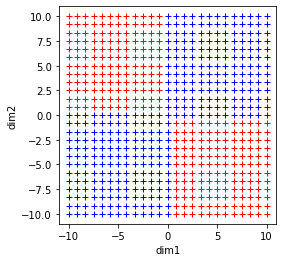

In [10]:
# generate test pattern array

xymin = -10
xymax = 10
Npts = 25
xv, yv = np.meshgrid(np.linspace(xymin, xymax, Npts), 
                     np.linspace(xymin, xymax, Npts))
test_pats = np.concatenate((xv.reshape((Npts*Npts,1)), 
                            yv.reshape((Npts*Npts,1))), axis=1)

print(test_pats[0])
print(test_pats[1])
print(test_pats[98])
print(test_pats[99])

test_labels_onehot = [0]*test_pats.shape[0]

# plot example
for idx in range((test_pats.shape[0])):
    point = test_pats[idx,:]
    if ((point[0] < 0 and point[1] > 0) or (point[0] > 0 and point[1]<0)):
        test_labels_onehot[idx] = 1
        plt.plot(point[0],point[1],'r+')
    else:
        plt.plot(point[0],point[1],'b+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
xymin = -5; xymax = 7.5
plt.show()

test_labels_onehot_array = np.array(test_labels_onehot).reshape((test_pats.shape[0],1))
test_labels_onehot_opened = [val[0] for val in test_labels_onehot_array]
test_labels_onehot_2D = np.array(test_labels_onehot_opened).reshape(len(test_labels_onehot_opened),1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
BINARY CLASSIFICATION!
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!


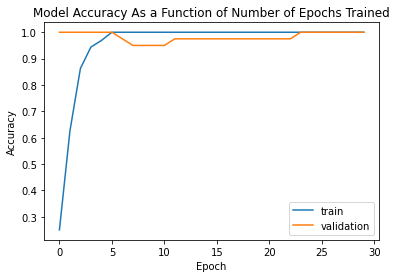

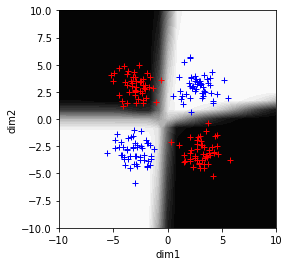

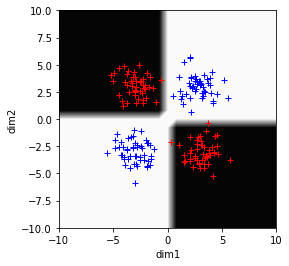

In [12]:
network_pip_bi2551, history_pip_bi2551, out_pip_bi2551 = run_pipeline(train_array, train_labels_onehot, test_pats, test_labels_onehot_2D, node_list=[2,5,5,1])

## Q4 (3 points)

Create your own classification problem for a neural network to learn.  Cannot be linearly separable, it can have as many classes as you'd like (as long as it's 2 or more).  If your problem has 2 classes, there must be more than one distribution per class. I want to see that the distribution that make up your problem have unequal variances and non-zero correlations.  Display your problem in a figure.

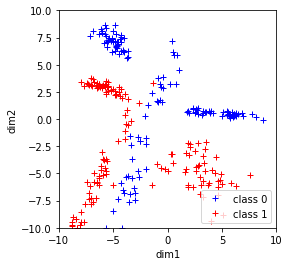

In [97]:
# classification problem used in Q4

# Center diagonal
mx0 = -2.;  my0 = -1.
sx0 = 2;  sy0 = 6
r0 = 0.96
# Right, long horizontal
mx1 = 5.; my1 = 0.5
sx1 = 2;  sy1 = 0.25
r1 = -0.75
# Top left
mx2 = -5; my2 = 7
sx2 = 0.86;  sy2 = 0.76
r2 = -0.7
#######################################################################
# Diagonal Right
mx4 = -6.; my4 = -5.
sx4 = 2; sy4 = 4
r4 = 0.97
# Bottom right
mx5 = 3.; my5 = -5.
sx5 = 2; sy5 = 1.5
r5 = -0.5
# Top left
mx6 = -6.; my6 = 3
sx6 = 1; sy6 = 0.5
r6 = -0.75
#######################################################################
N = 50
sample_0 = gensamples(N, mx0, my0, sx0, sy0, r0)
sample_1 = gensamples(N, mx1, my1, sx1, sy1, r1)
sample_2 = gensamples(N, mx2, my2, sx2, sy2, r2)
sample0 = np.concatenate((sample_0, sample_1, sample_2), axis=0)

sample_4 = gensamples(N, mx4, my4, sx4, sy4, r4)
sample_5 = gensamples(N, mx5, my5, sx5, sy5, r5)
sample_6 = gensamples(N, mx6, my6, sx6, sy6, r6)
sample1 = np.concatenate((sample_4, sample_5, sample_6), axis=0)

# plot example
plt.plot(sample0[:,0],sample0[:,1],'b+',sample1[:,0],sample1[:,1],'r+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
plt.legend(('class 0', 'class 1'), loc='lower right')
xymin = -10; xymax = 10
plt.ylim((xymin,xymax))
plt.xlim((xymin,xymax))
plt.show()

# All training patterns
train_array2 = np.concatenate((sample0, sample1), axis=0)
# Create the teacher
train_labels_onehot2 = np.concatenate((np.zeros((sample0.shape[0],1)), np.ones((sample1.shape[0],1))))

In [20]:
print(sample0.shape)
print(sample1.shape)

(150, 2)
(150, 2)


## Q5 and Q6 are shown in one fuction here:
## Q5 (5 points)

Create a multi-layer NN that can learn your problem.  Justiyf all choices. <br>
<br>
We will be looking to see that your network is reasonably small (number of layers and number of nodes per layer) to learn our problem (e.g. its complexity must be justified).  A network with several hidden layers and dozens of nodes per layer might learn your problem, but would be undoubtedly too complex to be justifiable. <br>
<br>
In a mark down cell, briefly document that different options you investiaged and why you chose the particular combinations you arrived at.

## Justifications and Iterations
1. I started with the same network structure as last time (e.g. of size 2,5,5,1), just as  a starting point, but presumably this network is much more complicated.  This was partially my own curciousity just to see how it would perform.  It performed okay, but it made triangles to cover the red class.  From the image, it was pretty clear that it just didn't have enough lines (thus needs more hidden layers/nodes) to sufficiently outline the red sections.  Thus I decided to add more hidden nodes/layers.
2. Increasing to a 2,8,8,1 network improved the performance in that more lines were used nad thus a finer resolution was achieved, but it was still "triangle like" instead of clean blocks.
3. I also wanted to test whether I could succeed with more hidden nodes instead of adding more layers.  Thus, using just 1 hidden layer, I used 12 nodes (size 2,12,1).  I arrived at 12 because if you look at the generated testing labels, it takes 11 "line segments" to make perfect blocks around the red.  I added one because I figured 11 by itself wouldn't be enough.  Looking at my results, I was right, and furthermore 12 was not enough, as this network performed worse than the above network (somewhat marginally worse, namely the right side was slightly connected even though there was blue in the connected region).
4. In order to completely rule out using just one hidden layer with lots of nodes, I used a 2,24,1 network, and it performed simiarly to the above network, again worse than the 2,8,8,1 network.  I stopped exploring few layers with high numbers of nodes after this.
5. Going back to multiple layers, I then tested a 2,12,12,12,1 network, continuing with the trend.  This time there was no connection between the right sides (thus this is the best performing so far).
6. My final iterations were to determine the minimal number of nodes and layer to replicate the above performance.  After a few tests I was able to determine that ____.

I chose to do binary classification instead of multiclass classification I didn't have to heavily edit plottest(), and I had already shown binary would work above.  I could have used multiclass classification by defining each cluser as it's own class, but I didn't see any advantage to switching.

## Q6 (2 points)
Create a plot of training accuracy as a function of epoch, and create a plot of both the loss and validation loss. Use plottest() again. You may need to edit the given function in this case to make it work with your problem.

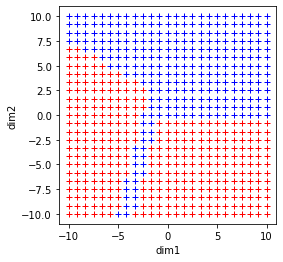

In [104]:
# generate test pattern array

xymin = -10
xymax = 10
Npts = 25
xv, yv = np.meshgrid(np.linspace(xymin, xymax, Npts), 
                     np.linspace(xymin, xymax, Npts))
test_pats = np.concatenate((xv.reshape((Npts*Npts,1)), 
                            yv.reshape((Npts*Npts,1))), axis=1)

test_labels_onehot = [0]*test_pats.shape[0]


def my_line1(x):
    y = -0.6*x + 1.5
    return y


def my_line2(x):
    y = 4*x + 10
    return y


def my_line3(x):
    y = 4*x + 4
    return y


# plot example
for idx in range((test_pats.shape[0])):
    point = test_pats[idx,:]
    if ((point[1] < my_line1(point[0])) and (point[1] > my_line2(point[0]))):
        plt.plot(point[0],point[1],'r+')
        test_labels_onehot[idx] = 1
    elif ((point[1] < 0) and (point[1] < my_line3(point[0]))):
        plt.plot(point[0],point[1],'r+')
        test_labels_onehot[idx] = 1
    else:
        # E.g. the default is blue.  I chose this since blue is more spread out whereas red is more concentrated
        plt.plot(point[0],point[1],'b+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
plt.show()

test_labels_onehot_array = np.array(test_labels_onehot).reshape((test_pats.shape[0],1))
test_labels_onehot_opened = [val[0] for val in test_labels_onehot_array]
test_labels_onehot_2D = np.array(test_labels_onehot_opened).reshape(len(test_labels_onehot_opened),1)

BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!


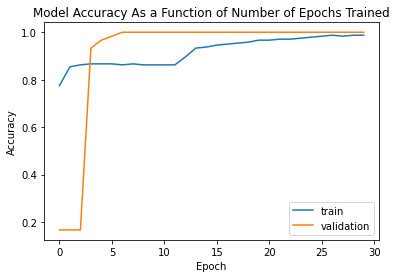

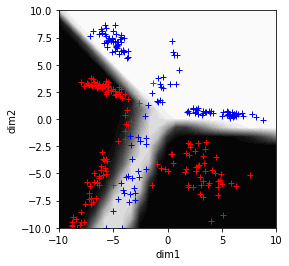

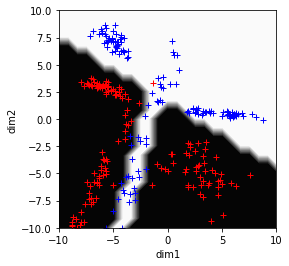

In [103]:
network_pip_bi2111, history_pip_bi2111, out_pip_bi2111 = run_pipeline(train_array2, train_labels_onehot2, test_pats, test_labels_onehot_2D, node_list=[2,6,6,6,1])

BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!
BINARY CLASSIFICATION!
Done training!


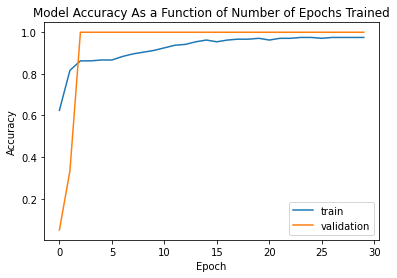

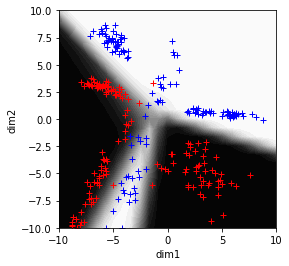

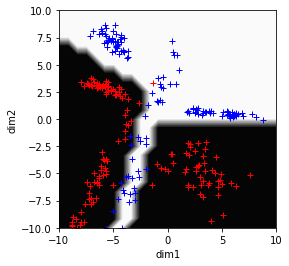

In [106]:
network_pip_bi2111, history_pip_bi2111, out_pip_bi2111 = run_pipeline(train_array2, train_labels_onehot2, test_pats, test_labels_onehot_2D, node_list=[2,5,5,1])

In [ ]:
network_pip_bi2111, history_pip_bi2111, out_pip_bi2111 = run_pipeline(train_array2, train_labels_onehot2, test_pats, test_labels_onehot_2D, node_list=[2,8,8,1])

In [ ]:
network_pip_bi2111, history_pip_bi2111, out_pip_bi2111 = run_pipeline(train_array2, train_labels_onehot2, test_pats, test_labels_onehot_2D, node_list=[2,8,8,8,1])